# Проект: ToxicScan — фильтрация комментариев c BERT

**Описание проекта:**

Интернет-магазин запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

**Цель проекта:** Обучить модель выявлять негативные/токсичные комментарии, со значением метрики качества `F1` не меньше `0.75`. 

В вашем распоряжении 

**Описание данных:**

- `toxic_comments.csv` — набор данных с разметкой о токсичности правок.

**Описание признаков:**

- `text` — текст комментария;
- `toxic` — целевой признак.

**Ход исследования:**

- `Подготовка данных`: загрузка и изучение общей информации из представленных данных.


- `Предобработка данных`: очищенние текста от управляющих символов, приведение к нижнему регистру, поиск дубликатов.


- `Исследовательский анализ данных`: изучение входного признака и таргета, анализ их распределений (длина комментариев, распределение классов), поиск выбросов/аномалий в данных.


- `Обучение моделей и выбор лучшей`: подготовка данных для обучения моделей с помощью получения эмбеддингов моделью `unitary/toxic-bert`, преобразование тензора в 2х мерный массив методом `mean_pooling` и построенных пайплайнов, использование `RandomizedSearchCV` для поиска гиперпараметров для моделей, сравнение метрик на кросс-валидации и выбор лучшей модели, лучшей моделью делаем прогноз на тестовых данных и проводит анализ результатов.


- `Общий вывод`: резюмирование полученных результатов, формулировка ключевых выводов и рекомендаций.

## Подготовка рабочей среды и вспомогательные функции

### Импорт библиотек и базовые настройки блокнота

In [1]:
# Стандартные библиотеки
import math
import os
import re
import time
import warnings

# Сторонние библиотеки
from lightgbm import LGBMClassifier
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
from scipy.stats import anderson
import seaborn as sns
from sklearn.calibration import CalibratedClassifierCV
from sklearn.decomposition import PCA
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (classification_report,
                             confusion_matrix, 
                             f1_score)
from sklearn.model_selection import (train_test_split, 
                                     cross_val_score, 
                                     cross_val_predict,
                                     RandomizedSearchCV)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (StandardScaler, 
                                   MinMaxScaler,
                                   Normalizer)
from sklearn.svm import LinearSVC
import torch
from transformers import AutoTokenizer, AutoModel
from tqdm import notebook
from wordcloud import WordCloud

# Базовые настройки блокнота
sns.set()
sns.set_context('paper')
pd.set_option('display.max_column', None)
pd.set_option('display.max_colwidth', None)

# Константы
RANDOM_STATE = 6011994
BATCH_SIZE = 32
MAX_LENGTH = 512
MODEL_NAME = 'unitary/toxic-bert'

# Убираем предупреждение о параллеризации
os.environ['TOKENIZERS_PARALLELISM'] = 'false'

# Убираем предупреждения для LightGBM
warnings.filterwarnings("ignore", message="X does not have valid feature names.*")

### Вспомогательные функции

In [2]:
# Функция для определения устройства
def get_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
        return torch.device('mps')
    else:
        return torch.device('cpu')

In [3]:
# Функция для анализа категорийных значений

def analyzis_category(df, title=None, kind='bar', rotation=0, top=None):
    '''
    Данная функция выводит столбчатый график
    по указанному столбцу датафрейма и его значения 
    в табличном виде.
    Аргументы функции:
    df - данные
    name - название графика
    kind - ориентация графика вертикальная или 
    горизонтальная, принимает значения "bar" и "barh".
    '''
    # Название для графика по умолчанию
    if title is None:
        title = f"Соотношение категорий {df.name if hasattr(df, 'name') else 'входного признака'}"
    
    # Подсчитываем количество каждого значения
    category_count = df.value_counts(ascending=True)
    
    if top == 'tail':
        category_count = category_count.head(10)
        
    elif top == 'head':
        category_count = category_count.tail(10)

    # Создание столбчатого графика
    plot_bar = category_count.plot(kind=kind, figsize=(8, 4.6), grid=True)

    # Настройка заголовка и подписей
    if kind == 'bar':
        plt.title(title, fontweight='bold', fontsize=12)
        plt.xlabel('')
        plt.ylabel('Частота', fontsize=10)
        plt.tick_params(axis='both', which='major', labelsize=10)
        plt.xticks(rotation=rotation)
    
    else:
        plt.title(title, fontweight='bold', fontsize=12)
        plt.xlabel('Частота', fontsize=10)
        plt.ylabel('')
        plt.tick_params(axis='both', which='major', labelsize=10)
        plt.xticks(rotation=rotation)

    # Отображаем график
    plt.tight_layout()
    plt.show()

    # Вывод значений в табличном виде
    display(pd.DataFrame(category_count).reset_index())

In [4]:
# Функция для комплексного анализа количественного признака
def analyzis_quantity(df, x_label, y_label='Частота', target=None, 
                      hue=None, size=None, sizes=None, system=False, 
                      discrete=False, log_scale=False, title_hist=None, 
                      title_scatter=None):
    '''
    Данная функция выводит "коробочный" график и гистограмму 
    по указанному столбцу датафрейма и его статистические метрики.
    Аргументы функции:
    df - данные (pd.Series)
    x_label - подпись для оси Х
    y_label - подпись для оси Y (по умолчанию "Частота")
    target - целевая переменная для scatter-графика (если system=True)
    hue - переменная для цветового кодирования (если system=True)
    size - переменная кодирования по размеру (если system=True)
    sizes - переменная для уточнения диапозона кодировки размеров (если system=True)
    system - флаг для построения scatter-графика
    discrete - булевое значение, дискретные значение или нет.
    log_scale - логарифмическая шкала для гистограммы
    title_hist - заголовок для гистограммы и boxplot
    title_scatter - заголовок для scatter-графика
    '''

    # Названия для графиков по умолчанию
    if title_hist is None:
        title_hist = f"Распределение {df.name if hasattr(df, 'name') else 'входной признак'}"
    if title_scatter is None:
        target_name = target.name if hasattr(target, 'name') else 'таргета'
        feature_name = df.name if hasattr(df, 'name') else 'входной признак'
        title_scatter = f"Зависимость {target_name} от {feature_name}"
    
    # Создание составного графика: boxplot + histogram
    fig, (ax_box, ax_hist) = plt.subplots(2, sharex=True, 
                                          figsize=(8, 5.6), 
                                          gridspec_kw={'height_ratios': (.15, .85)})
    
    # Boxplot
    sns.boxplot(x=df, orient='h', ax=ax_box)
    ax_box.set(xlabel='')

    # Histogram
    n_bins = round(1 + math.log2(len(df))) if len(df) > 1 else 10
    sns.histplot(x=df, bins=n_bins, discrete=discrete, log_scale=log_scale, ax=ax_hist)

    # Общие настройки для основной фигуры
    ax_hist.set_xlabel(x_label, fontsize=10)
    ax_hist.set_ylabel(y_label, fontsize=10)
    ax_hist.tick_params(axis='both', which='major', labelsize=10)
    fig.suptitle(title_hist, fontsize=12, fontweight='bold', y=0.95)

    # Настройка тиков для дискретных значений
    if discrete == 'unique':
        unique_vals = np.sort(df.dropna().unique())
        ax_hist.set_xticks(unique_vals)
    elif discrete == 'non_unique':
        ax_hist.set_xticks(np.arange(df.min(), df.max() + 1, 1))

    # Отображение первой фигуры
    fig.tight_layout()

    # Scatter plot (если запрошено)
    if system:
        if hue is not None:
            fig_2, ax_2 = plt.subplots(figsize=(10, 5.34))
        else:
            fig_2, ax_2 = plt.subplots(figsize=(8, 5.34))
        sns.scatterplot(x=df, y=target, alpha=0.5, hue=hue, size=size, sizes=sizes, ax=ax_2)
        fig_2.suptitle(title_scatter, fontsize=12, fontweight='bold', y=0.95)
        ax_2.set_xlabel(x_label, fontsize=10)
        ax_2.set_ylabel(target.name if hasattr(target, 'name') else 'Целевая переменная', fontsize=10)
        ax_2.tick_params(axis='both', which='major', labelsize=10)
        if hue is not None:
            ax_2.legend(bbox_to_anchor=(1.025, 1), loc='upper left', fontsize=10)
        fig_2.tight_layout()
        if log_scale:
            plt.xscale('log')
            plt.yscale('log')

    # Отображение графика
    plt.show()

    # Вывод статистических метрик
    display(df.describe().to_frame().T)
        
    # Проверяем нормальность распределения
    result = anderson(df.dropna())
    
    if result.statistic < result.critical_values[2]:
        distr = 'Нормальное'
    else:
        distr = 'Не является нормальным'

    test_anderson = {'':['Статистика:', 
                         "Критические значения:", 
                         'Распределение'], 
                     'Тест на нормальность распределения (порог=0.05):': [result.statistic, 
                                                                          result.critical_values, 
                                                                          distr]
                    }
    display(pd.DataFrame(test_anderson).set_index(''))

In [5]:
# Функция для очистки комментариев от управляющих символов
def clean_text(text):
    return re.sub(r'\s+', ' ', text).strip().lower()

In [6]:
def mean_pooling(model_output, attention_mask):
    '''
    Функция для усреднения эмбеддингов по токенам с attention mask
    '''
    token_embeddings = model_output.last_hidden_state
    input_mask_expanded = attention_mask.unsqueeze(-1)\
                                        .expand(token_embeddings.size())\
                                        .float()
    sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, dim=1)
    sum_mask = torch.clamp(input_mask_expanded.sum(dim=1), min=1e-9)
    return sum_embeddings / sum_mask

In [7]:
def encode_texts(text, tokenizer, model, device, batch_size, max_length):
    '''
    Функция кодирует список текстов в эмбеддинги 
    с помощью BERT.
    
    Возвращает NumPy массив размером (N, 768).
    '''
    all_embeddings = []

    for i in notebook.tqdm(range(0, len(text), batch_size)):
        # Получение батча
        batch_text = text[i:i + batch_size]

        # Токенизация
        inputs = tokenizer(
            batch_text, 
            return_tensors='pt', 
            padding=True, 
            truncation=True, 
            max_length=max_length
        ).to(device)

        with torch.no_grad():
            outputs = model(**inputs)
            embeddings = mean_pooling(outputs, inputs['attention_mask'])
            all_embeddings.append(embeddings.cpu())

    final_embeddings = torch.cat(all_embeddings, dim=0)
    return final_embeddings.numpy()

In [8]:
# Функция для подбора оптимального уровня порога классификации
def best_threshold(model, X, y, thresholds, name, cv=3):
    proba = cross_val_predict(model, 
                              X, 
                              y, 
                              cv=cv,
                              method='predict_proba')[:, 1]
    scores = [f1_score(y, proba >= t) for t in thresholds]
    threshold = round(thresholds[np.argmax(scores)], 2)
    report = classification_report(y, proba >= threshold)

    print(f'{name}:')
    print('Оптимальный порог классификации:', threshold)
    print('Метрики классификации при оптимальном пороге:\n')
    print(report)

    return threshold

### Определяем устройство

In [9]:
device = get_device()
print(f'Используемое устройство: {device}')

Используемое устройство: mps


## Общая информация о данных

### Загрузка данных

In [10]:
df = pd.read_csv('../data/toxic_comments.csv', index_col=[0])

### Общая информация о таблице

In [11]:
print(df.info())
display(df.head())
display(df.sample(5, random_state=RANDOM_STATE))

<class 'pandas.core.frame.DataFrame'>
Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB
None


,text,toxic
0,"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",0
1,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, January 11, 2016 (UTC)",0
2,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.",0
3,"""\nMore\nI can't make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of """"types of accidents"""" -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any preferences for formatting style on references or want to do it yourself please let me know.\n\nThere appears to be a backlog on articles for review so I guess there may be a delay until a reviewer turns up. It's listed in the relevant form eg Wikipedia:Good_article_nominations#Transport """,0
4,"You, sir, are my hero. Any chance you remember what page that's on?",0


,text,toxic
140421,"Yeah, no, the Weebly founders did not know of Cool 'N' Fast Cars. I know it was just a troll adding such a website, claiming to be Chris Fanini in Test/1; what a crude impersonation! He needs to take a look at Weebly's Terms of Service. 198.228.217.170",0
128895,"""\n\n Hiatus? \n\nEminem is finally done with his hiatus.\nWhere it says that he released his album since 2004, Relapse you should write that his hiatus ended in 2009 and that he came back.\n-⊕ talk""",0
12330,"""\nOy vey. You won't underestimate my WP:DENSEity again, will you? No tone of voice in text, and a large part of my suprise and dismay was that it seemed so out of character for you. I was actually thinking of edits themselves, disk space etc. I didn't express that well, and once I checked it's a low-use bot, and it was a tiny aside anyway! Thank you for your graceful reply, sorry to have diverted your resources to straightening me out. ;)(t)(c) """,0
111415,Fixed it for you. 77.22.144.77,0
21709,".\n\nMuhammad was a dirty warmonger, murderer, rapist and thief",1


### Вывод:

- Данные соответствуют описанию, все объявленные колонки в данных присутствуют;
- Мы имеет почти `160 тысяч` комментариев с разметкой о токсичности;
- По первым и `5` рандомным строкам данных можем судить, что большинство или все комментарии на английском языке;
- В комментариях указаны символы новой строки — `\n`, они сливаются с другими словами, необходимо от них избавиться;
- Необходимо проверить наличие явных дубликатов в данных;
- Судя по индексу в данных несколько комментариев было удалено, для удобства обновим индекс, чтобы он был без пропусков в значениях.

## Предобработка данных

### Обновление индекса

In [12]:
df = df.reset_index(drop=True)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


Обновили индекс и датафрейм стал занимать на `30 %` памяти меньше.

### Очистка комменатриев от символа новой строки

По скольку в комментариях абзацы и отступы не несут большой информации очистим их от данных символов. Дополнительно переведем все слова в нижний регистр. 

In [14]:
df['text'] = df['text'].apply(clean_text)
df.sample(5, random_state=RANDOM_STATE)

,text,toxic
140269,"yeah, no, the weebly founders did not know of cool 'n' fast cars. i know it was just a troll adding such a website, claiming to be chris fanini in test/1; what a crude impersonation! he needs to take a look at weebly's terms of service. 198.228.217.170",0
128763,""" hiatus? eminem is finally done with his hiatus. where it says that he released his album since 2004, relapse you should write that his hiatus ended in 2009 and that he came back. -⊕ talk""",0
12316,""" oy vey. you won't underestimate my wp:denseity again, will you? no tone of voice in text, and a large part of my suprise and dismay was that it seemed so out of character for you. i was actually thinking of edits themselves, disk space etc. i didn't express that well, and once i checked it's a low-use bot, and it was a tiny aside anyway! thank you for your graceful reply, sorry to have diverted your resources to straightening me out. ;)(t)(c) """,0
111318,fixed it for you. 77.22.144.77,0
21689,". muhammad was a dirty warmonger, murderer, rapist and thief",1


Комментарии стали чище и их стало легче воспринимать.

### Дубликаты

In [15]:
df.duplicated().sum()

np.int64(245)

In [16]:
df = df.drop_duplicates().reset_index(drop=True)

Датафрейм очищен от явных дубликатов.

### Вывод:

Данные предобработаны:

- Исправлен индекс;
- Текст очищен от управляющих символов;
- Удалены явные дубликаты.

## Исследовательский анализ

### Toxic — целевая переменная

Рассмотрим соотношение классов.

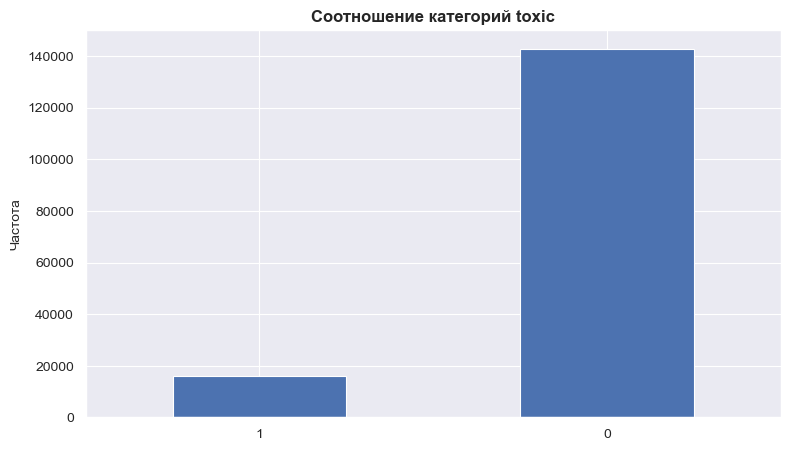

,toxic,count
0,1,16143
1,0,142904


,Оценка комментария,Доля
0,Не негативные,0.899
1,Негативные,0.101


In [17]:
analyzis_category(df['toxic'])

data = {
    'Оценка комментария': ['Не негативные', 
                           'Негативные'], 
    'Доля': [(1 - df['toxic'].mean()).round(3), 
             df['toxic'].mean().round(3)]
}

display(pd.DataFrame(data))

Негативные комментарии составляют `~10 %` от их общего числа.

### Анализ облака слов

In [18]:
# Делим текст по классам
toxic_text = ''.join(df.loc[df['toxic'] == 1, 'text'].astype(str))
untoxic_text = ''.join(df.loc[df['toxic'] == 0, 'text'].astype(str))

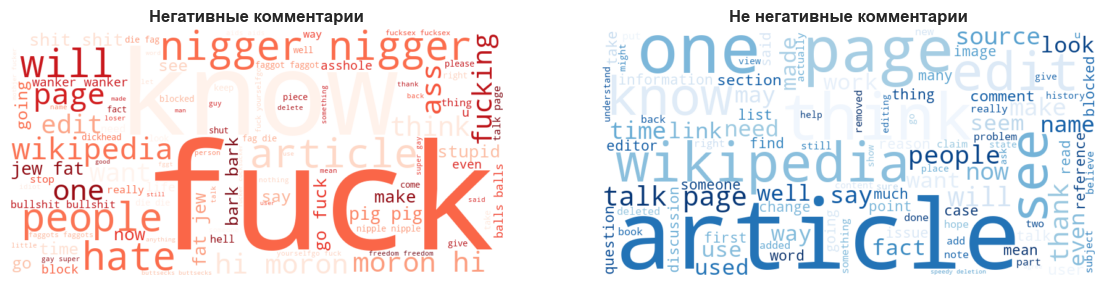

In [19]:
# Построение графиков
wc_toxic = WordCloud(
    width=800, 
    height=400,
    background_color='white',
    max_words=100,
    colormap='Reds'
).generate(toxic_text)

wc_untoxic = WordCloud(
    width=800, 
    height=400,
    background_color='white',
    max_words=100,
    colormap='Blues'
).generate(untoxic_text)

plt.figure(figsize=(14, 4.6))

plt.subplot(1, 2, 1)
plt.imshow(wc_toxic, interpolation='bilinear')
plt.title('Негативные комментарии', fontweight='bold', fontsize=12)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(wc_untoxic, interpolation='bilinear')
plt.title('Не негативные комментарии', fontweight='bold', fontsize=12)
plt.axis('off')

plt.show()

На графике с негативными комментариями видно много нецензурной лексики, что может служить основным фактором классификации комментариев.

### Анализ длин комментариев

По скольку мы будем использовать модель `unitary/toxic-bert` для эмбеддинга, нам необходимо проверить, не превышают комментарии максимальную длину, которую принимает модель.

In [20]:
# Длина текста в символах и словах (грубая оценка)
df['len_symbol'] = df['text'].str.len()
df['len_word'] = df['text'].str.split().str.len()

#### Оценка длин текстов в символах

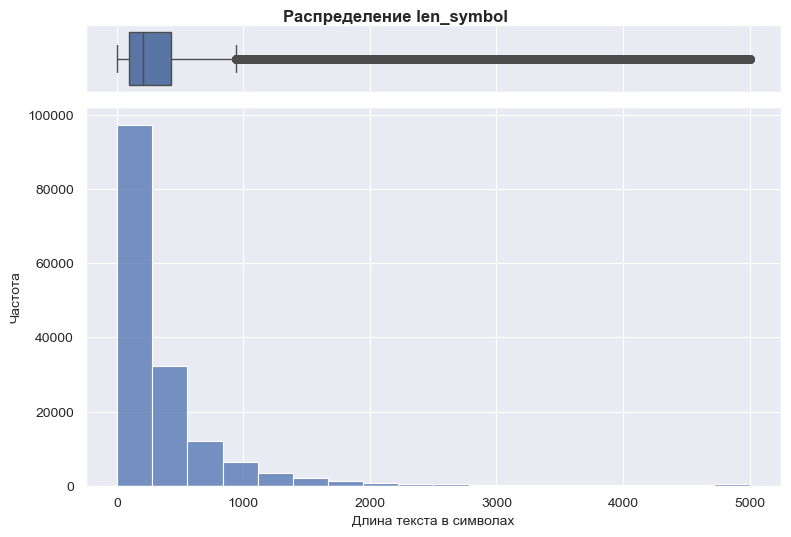

,count,mean,std,min,25%,50%,75%,max
len_symbol,159047.0,390.603702,585.953524,3.0,94.0,203.0,432.0,5000.0


,Тест на нормальность распределения (порог=0.05):
,
Статистика:,19030.998761
Критические значения:,"[0.576, 0.656, 0.787, 0.918, 1.092]"
Распределение,Не является нормальным


,toxic,mean,median
0,0,400.793827,214.0
1,1,300.396828,126.0


In [21]:
analyzis_quantity(df['len_symbol'], x_label='Длина текста в символах')
df.groupby('toxic', as_index=False)['len_symbol'].agg(['mean', 'median'])

Мы получили положительно скошенное распределение с сильными выбросами, средняя длина комментариев — `203` символа, размах распределения составляет `4997` символа.

Так же замечено, что токсичные комментарии обычно короче остальных.

#### Оценка длин текстов в словах

Данная оценка осуществляется с грубым предположением, что все слова разделены пробелом.

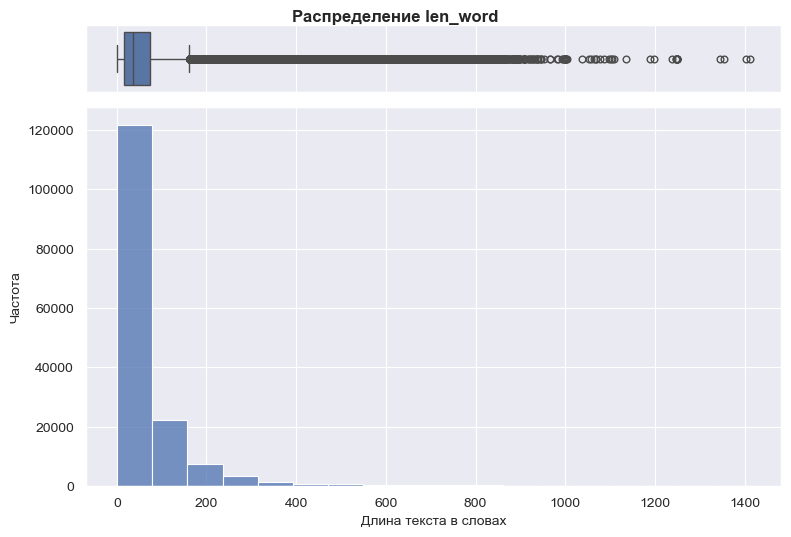

,count,mean,std,min,25%,50%,75%,max
len_word,159047.0,67.223965,99.168094,1.0,17.0,36.0,75.0,1411.0


,Тест на нормальность распределения (порог=0.05):
,
Статистика:,18494.27477
Критические значения:,"[0.576, 0.656, 0.787, 0.918, 1.092]"
Распределение,Не является нормальным


,toxic,mean,median
0,0,68.862565,37.0
1,1,52.718454,23.0


In [22]:
analyzis_quantity(df['len_word'], x_label='Длина текста в словах')

df.groupby('toxic', as_index=False)['len_word'].agg(['mean', 'median'])

Мы тут так же наблюдаем положительно скошенное распределение с сильными выбросами. Средняя длина комментария — `36` слов, размах распределения `1410`.

Зависимость, что токсичные комментарии короче остальных, сохраняется.

#### Анализ длин текстов после токенизации

В виду того, что максимальное количество токенов, которое может получить на вход модель `DistilBERT` — `512` токенов, а по распределению выше такие комментарии присутствуют, оценим долю таких комментариев, которые нам придется обрезать и лишаться части их контекста.

In [23]:
# Инициализация токенизатора
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)

In [24]:
# Подсчет длин токенов
df['n_tokens'] = df['text'].apply(lambda x: len(tokenizer.encode(x, add_special_tokens=True)))

Token indices sequence length is longer than the specified maximum sequence length for this model (631 > 512). Running this sequence through the model will result in indexing errors


Как и ожидалось, мы получили предупреждение, что некоторые тексты превышают эту длину.

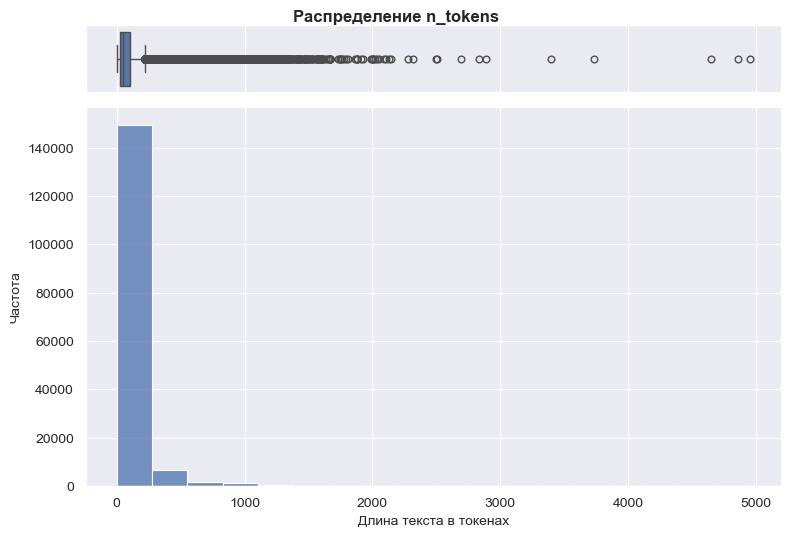

,count,mean,std,min,25%,50%,75%,max
n_tokens,159047.0,94.816809,141.353317,4.0,26.0,52.0,104.0,4950.0


,Тест на нормальность распределения (порог=0.05):
,
Статистика:,19588.261115
Критические значения:,"[0.576, 0.656, 0.787, 0.918, 1.092]"
Распределение,Не является нормальным


,toxic,mean,median
0,0,96.360424,54.0
1,1,81.152140,36.0



Доля текстов, превышающих порог в 512 токенов:


,,Доля
0,Все комментарии,0.022
1,Не негативные,0.020
2,Негативные,0.002


In [25]:
analyzis_quantity(df['n_tokens'], x_label='Длина текста в токенах')

display(df.groupby('toxic', as_index=False)['n_tokens'].agg(['mean', 'median']))

print('\nДоля текстов, превышающих порог в 512 токенов:')
all_text = (df['n_tokens'] > 512).mean()
output = df[(df['toxic'] == 0) & (df['n_tokens'] > 512)].shape[0] / df.shape[0]
data = {
    '': ['Все комментарии', 'Не негативные', 'Негативные'],
    'Доля': [round(all_text, 3), 
             round(output, 3), 
             round(all_text - output, 3)]
}
display(pd.DataFrame(data))

Около `2%` от всех комментариев превышают доступный порог в `512` токенов. В виду того, что в продакшене мы не можем игнорировать все длинные комментарии, поэтому справедливо будет оставить эти данные и оценивать качество модели вместе с ними, а все длинные комментарии обрежем до фиксированной длины в `512` токенов.

### Рассмотрение примеров комментариев выделенных классов

#### Не негативные примеры

Прежде, чем приступать к обучению модели, стоит самостоятельно оценить возможность классификации данных комментариев.

In [26]:
# Не негативные комментарии
df[df['toxic'] == 0].sample(3, random_state=RANDOM_STATE).iloc[:, [0, 1]]

,text,toxic
47760,"""cab, your not korean or korea specialist. have you done any research on korea??? if not please refrain yourself making any kinds of judgements toward opinion different from yours. i have been very patient with you. your comments and your articles on topic ( koreans and yanbian province history) is very bias. on the side note manchuria was never part of china. china itself is very superficial state. what claims to be chinese culture or chinese provinces is very superficial. please keep that in mind when you comment on others who disagree with you. in another words be """" open minded person"""" to other people's opinions. yanbian province never have been part or populated by """" antu"""" tribes. please get your facts straight. read your history. """,0
68339,i guess we will have to disagree on this one,0
100961,i can't see any answar to your act? comanche cph,0


Перевод *(применен машинный перевод)*:

1. `«Каб, ты не корейский специалист и не специалист по Корее. Ты проводил какие-нибудь исследования по Корее??? Если нет, то, пожалуйста, воздержись от каких-либо суждений в отношении мнений, отличных от твоего. Я был очень терпелив с тобой. Твои комментарии и статьи по теме (корейцы и история провинции Яньбянь) очень предвзяты. Кстати, Маньчжурия никогда не была частью Китая. Сам Китай — очень поверхностное государство. То, что считается китайской культурой или китайскими провинциями, очень поверхностно. Пожалуйста, имейте это в виду, когда комментируете других, которые с вами не согласны. Другими словами, будьте «открытым человеком» по отношению к мнениям других людей. Провинция Яньбянь никогда не была частью «анту» племен и не была заселена ими. Пожалуйста, уточните факты. Прочитайте историю».`

2. `Думаю, в этом вопросе мы будем расходиться во мнениях.`

3. `Я не вижу никакого ответа на твой поступок? Команч CPH` *(судя по всему в конце либо опечатка, либо сленг)*

В этих комментариях действительно нет прямых оскорблений, несмотря на накаленную обстановку в первом примере.

#### Негативные примеры

In [27]:
# Негативные комментарии
df[df['toxic'] == 1].sample(3, random_state=RANDOM_STATE).iloc[:, [0, 1]]

,text,toxic
97843,going to sort you out so you're back eh? i haven't forgotten. you're going to get it you little shit. i have horrible things planned for you!,1
33362,i hate you how dare you delete my post. you better put it back or i am going to fuck you up,1
151100,""" hi, pompous ass! ;) i know you think you're some kind of poker authority on wikipedia, and that it's somehow your perogative to give the imperial final thumbs up or thumbs down on what's acceptable regarding anything to do with poker here, but guess what? that's not the case. you are one of many arrogant, conceited, self-absorbed losers that populate wikipedia who use this site as some sort of self-esteem builder, because here you can act like a """"big man"""", and make unilateral decisions on what's acceptable or unacceptable here. the edits i have made (and will continue to make) on the jack straus entry regarding his death doesn't violate policy in any way. if i had the time or the inclination, i could spend several months quoting entries and instances on wikipedia where editorial verbiage is used. you are simply a pompous ass who thinks you are the gatekeeper of anything poker-related on wikipedia. you are not, and you will not censor me. and as i'm sure you've already realized, my isp address constantly changes, so you won’t be able to block me, either. so piss off. ;)""",1


Перевод *(применен машинный перевод)*:

1. `Я с тобой разберусь, так что вернись, ладно? Я не забыл. Ты за это поплатишься, мелкий гаденыш. Я приготовил для тебя ужасные вещи!`

2. `Я тебя ненавижу, как ты смеешь удалять мои посты. Лучше верни его, или я тебя раздавлю.`

3. `«Привет, напыщенный осёл! ;) Я знаю, что ты считаешь себя каким-то авторитетом в области покера на Википедии и что, по-твоему, только тебе полагается давать имперское окончательное одобрение или неодобрение тому, что приемлемо в отношении всего, что связано с покером здесь, но знаешь что? Это не так. Ты один из многих высокомерных, самодовольных, самоувлеченных неудачников, которые населяют Википедию и используют этот сайт как средство для повышения самооценки, потому что здесь ты можешь вести себя как «большой человек» и принимать односторонние решения о том, что здесь приемлемо, а что нет. Изменения, которые я внес (и буду вносить) в статью о Джеке Страусе в отношении его смерти, никоим образом не нарушают политику. Если бы у меня было время или желание, я мог бы потратить несколько месяцев на цитирование статей и примеров из Википедии, где используется редакционная лексика. Вы просто напыщенный осёл, который считает себя стражем всего, что касается покера в Википедии. Вы им не являетесь и не будете меня цензурировать. И, как вы, наверное, уже поняли, мой IP-адрес постоянно меняется, так что вы не сможете меня заблокировать. Так что отвалите. ;)»`

Да, мы видим, что факторы, которые указывают на токсичность — это прямые оскорбления или угрозы.

### Вывод:

На данном этапе мы провели `EDA` и сделали следующие выводы о данных:

**Баланс классов:** 

Негативные комментарии составляют `~10 %` от общего числа комментариев.

**Анализ облака слов:**

На графике с негативными комментариями видно много нецензурной лексики, что может служить основным фактором классификации комментариев.

**Анализ длин комментариев:**

- `Длина в символах` — получили положительно скошенное распределение с сильными выбросами, средняя длина комментариев — `203` символа, размах распределения составляет `4997` символа. Так же замечено, что токсичные комментарии обычно короче остальных.
- `Длина в словах` *(данная оценка осуществляется с грубым предположением, что все слова разделены пробелом)* — наблюдаем положительно скошенное распределение с сильными выбросами. Средняя длина комментария — `36` слов, размах распределения `1410`. Зависимость, что токсичные комментарии короче остальных, сохраняется.
- `Длина в токенах` — около `2%` от всех комментариев превышают доступный порог в `512` токенов. В виду того, что в продакшене мы не можем игнорировать все длинные комментарии, поэтому справедливо будет оставить эти данные и оценивать качество модели вместе с ними, а все длинные комментарии обрежем до фиксированной длины в `512` токенов.

**Рассмотрение примеров комментариев разных классов:**

Факторы, которые указывают на токсичность — это прямые оскорбления или угрозы.

## Подготовка данных для обучения моделей

На данном этапе наша задаче преобразовать текст так, чтобы получить данные в таком виде, чтобы их можно было использовать для обучения моделей.

Это мы сделаем с помощью получения эмбеддингов, в виду того, что модель `unitary/toxic-bert` уже дообучена под нашу задачу мы будем брать эмбеддинги токена `[CLS]` для обучения классических алгоритмов ML.

### Деление данных на тренировочную и тестовую выборки

In [28]:
# Входные данные
X = df['text']
# Таргет
y = df['toxic']

In [29]:
# Деление на выборки
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y,
    test_size=0.25,
    stratify=y, 
    random_state=RANDOM_STATE
)

In [30]:
# Проверяем корректность деления данных
print('Размер тренировочных данных', X_train.shape, y_train.shape)
print('Размер тестовых данных', X_test.shape, y_test.shape)

Размер тренировочных данных (119285,) (119285,)
Размер тестовых данных (39762,) (39762,)


Данные разделены корректно.

### Получение эмбеддингов

In [31]:
# Инициализируем модель
model_bert = AutoModel.from_pretrained(MODEL_NAME).to(device)
model_bert.eval()

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

#### Тренировочные входные данные

In [32]:
try:
    X_train = np.load('../data/emb_train_toxic.npy')
except:
    texts = X_train.fillna('').tolist()
    X_train = encode_texts(
        texts, 
        tokenizer, 
        model_bert, 
        device, 
        batch_size=BATCH_SIZE, 
        max_length=MAX_LENGTH
    )

In [33]:
# Проверяем полученные результат
print('Класс массива:', type(X_train))
print('Размер массива:', X_train.shape)
print('Тип значений в признаках:', X_train.dtype)

Класс массива: <class 'numpy.ndarray'>
Размер массива: (119285, 768)
Тип значений в признаках: float32


Преобразование прошло корректно.

#### Тестовые входные данные

In [34]:
try:
    X_test = np.load('../data/emb_test_toxic.npy')
except:
    texts = X_test.fillna('').tolist()
    X_test = encode_texts(
        texts, 
        tokenizer, 
        model_bert, 
        device, 
        batch_size=BATCH_SIZE, 
        max_length=MAX_LENGTH
    )

In [35]:
# Проверяем полученные результат
print('Класс массива:', type(X_test))
print('Размер массива:', X_test.shape)
print('Тип значений в признаках:', X_test.dtype)

Класс массива: <class 'numpy.ndarray'>
Размер массива: (39762, 768)
Тип значений в признаках: float32


Преобразование прошло корректно.

## Обучение

**Выбор метрики:**

У нас бинарная классификация с довольно сильным дисбалансом классов, который необходимо учитывать, и нам в ТЗ поставлена задача, чтобы качество метрики `F1` было не меньше `0.75`. Исходя из этого, принято решение использовать метрику `PRAUC` для оптимизации моделей и дополнительно отслеживать `F1`, чтобы отслеживать, достигли ли модели необходимого качества. Так же дополнительно будем рассматривать `Precision` и `Recall`, так как только одна метрика `F1` не дает нам полной картины качества модели.

- `PRAUC` — метрика оптимизации моделей;
- `Precision` — дополнительная оценка;
- `Recall` — дополнительная оценка;
- `F1` — итоговая оценка, исходя из ТЗ. 

**Рассматриваемые модели:**

Выбирать лучше модель будем из следующих:

- `DummyClassifier` — Baseline;
- `LogisticRegression` — линейная модель, как самая легкая и самая быстрая модель из всех претендентов;
- `LinearSVC`  — линейная модель, часто хорошо себя показывает в подобных задачах;
- `KNeighborsClassifier` — алгоритм `k-ближайших соседей`, в виду того, что входные признаки представляют из себя векторы, логично будет попробовать модель, которая принимает решения, основываясь на расстояниях между векторами;
- `LGBMClassifier` - `boosting` модель основанная на деревьях решений, самая сложная модель из всех претендентов.

### Инициализация метрик

In [36]:
scoring = {
    'pr_auc': 'average_precision',
    'f1': 'f1',
    'prec': 'precision',
    'rec': 'recall'
}

### Пайплайн для обучения моделей

In [37]:
pipe = Pipeline([
    ('norm', Normalizer(norm='l2')),
    ('scaler', 'passthrough'),
    ('pca', PCA(n_components=256)),
    ('model', LogisticRegression())
])

### Инициализация поиска гиперпараметров и словари к ним

#### DummyClassifier

In [38]:
dummy = cross_val_score(
    DummyClassifier(strategy='constant', constant=1), 
    X_train, 
    y_train, 
    cv=3, 
    scoring='f1'
)

#### LogisticRegression

In [39]:
# Словарь поиска гиперпараметров
param_lr = {
    'model': [LogisticRegression(max_iter=5000,
                                 tol=1e-3,
                                 solver='saga', 
                                 penalty='elasticnet', 
                                 class_weight='balanced',
                                 random_state=RANDOM_STATE)],
    'scaler': [StandardScaler(), MinMaxScaler()], 
    'model__l1_ratio': np.round(np.arange(0.0, 1.01, 0.1), 2).tolist(),
    'model__C': [0.01, 0.1, 1, 10, 100]
}

In [40]:
# Инициализация поиска гиперпараметров
search_lr = RandomizedSearchCV(
    pipe, 
    param_lr, 
    n_iter=10,
    cv=3, 
    scoring=scoring,
    refit='pr_auc',
    n_jobs=-1,
    random_state=RANDOM_STATE
)

#### LinearSVC

В виду того, что `LinearSVC` не дает вероятности, обернем ее в `CalibratedClassifierCV`.

In [41]:
# Инициализация модели
svc = LinearSVC(max_iter=2000, 
                dual=False,
                class_weight='balanced', 
                random_state=RANDOM_STATE)

calibrated_svc = CalibratedClassifierCV(svc, 
                                        method='sigmoid', 
                                        cv=3)

In [42]:
# Словарь поиска гиперпараметров
param_svc = {
    'model': [calibrated_svc],
    'scaler': [StandardScaler(), MinMaxScaler()],
    'model__estimator__C': [0.01, 0.1, 1, 10, 100]
}

In [43]:
# Инициализация поиска гиперпараметров
search_svc = RandomizedSearchCV(
    pipe, 
    param_svc, 
    n_iter=5,
    cv=3,
    scoring=scoring,
    refit='pr_auc',
    n_jobs=-1,
    random_state=RANDOM_STATE
)

#### KNeighbosClassifier

In [44]:
# Словарь поиска гиперпараметров
param_knn = {
    'model': [KNeighborsClassifier(metric='cosine', 
                                   algorithm='brute')],
    'model__n_neighbors': list(range(3, 16, 2)),
    'model__weights': ['uniform', 'distance'],
}

In [45]:
# Инициализация поиска гиперпараметров
search_knn = RandomizedSearchCV(
    pipe, 
    param_knn, 
    n_iter=5,
    cv=3, 
    scoring=scoring,
    refit='pr_auc',
    n_jobs=-1,
    random_state=RANDOM_STATE
)

#### LGBMClassifier

In [46]:
# Словарь поиска гиперпараметров
param_lgbm = {
    'model': [LGBMClassifier(subsample=0.8,
                             colsample_bytree=0.8,
                             objective='binary',
                             verbosity=-1,
                             random_state=RANDOM_STATE)],
    'model__max_depth': list(range(3, 9)),
    'model__num_leaves': [15, 31, 63, 127],
    'model__n_estimators': list(range(100, 900, 100)),
    'model__learning_rate': np.round(np.arange(0.01, 0.21, 0.01), 2).tolist(),
    'model__min_child_samples': [20, 50, 100, 150],
    'model__reg_lambda': [0.01, 0.1, 1, 10],
    'model__scale_pos_weight': [5, 7, 9, 11, 13]
}

In [47]:
# Инициализация поиска гиперпараметров
search_lgbm = RandomizedSearchCV(
    pipe, 
    param_lgbm, 
    n_iter=30,
    cv=3, 
    scoring=scoring, 
    refit='pr_auc',
    n_jobs=1,
    random_state=RANDOM_STATE
)

### Поиск гиперпараметров и выбор лучшей модели

In [48]:
# Словарь и список необходимые для обучения моделей
result_data = []

models = {
    'Dummy': dummy,
    'LogisticRegression': search_lr,
    'LinearSVC': search_svc,
    'k-NN': search_knn,
    'LightGBM': search_lgbm
}

In [49]:
# Цикл обучения моделей
for name, search in models.items():
    
    # Обучение моделей и поиск гиперпараметров
    if name == 'Dummy':
        print('=' * 90)
        print(f'Обучение модели: {name}')
        print(f'Метрика F1-score: {np.mean(dummy):.4f} ± {np.std(dummy):.4f}')
        
        # Сохраняем результат
        result_data.append({
            'Model': name,
            'Best_CV_score': ' — ',
            'F1_CV_score': f'{np.mean(dummy):.4f} ± {np.std(dummy):.4f}',
            'Precision_CV_score': ' — ',
            'Recall_CV_score': ' — ',
            'Best_params': ' — '
        })
        
        continue
        
    print('=' * 90)
    print(f'Обучение модели: {name}')
    start = time.time()
    search.fit(X_train, y_train)
    end = time.time()

    # Получаем метрику F1
    model_result = pd.DataFrame(search.cv_results_)
    best_idx = search.best_index_
    f1 = model_result.loc[best_idx, 'mean_test_f1']
    prec = model_result.loc[best_idx, 'mean_test_prec']
    rec = model_result.loc[best_idx, 'mean_test_rec']
    
    # Сохраняем лучшие результаты
    result_data.append({
        'Model': name,
        'Best_CV_score': f'{search.best_score_:.4f}',
        'F1_CV_score': f'{f1:.4f}',
        'Precision_CV_score': f'{prec:.4f}',
        'Recall_CV_score': f'{rec:.4f}',
        'Best_params': search.best_params_
    })
    
    # Логирование результатов обучения моделей
    print(f'Время обучения модели: {(end - start) / 60:.1f} минут')
    print(f'Лучшая метрика F1-score на кросс-валидации: {f1:.4f}')
    print('\nПодробнее:')
    display(model_result.sort_values(by='rank_test_pr_auc')
                        .loc[:, 'split0_test_pr_auc':'std_test_pr_auc']
                        .head(3))
    
    
# Вывод итоговой таблицы результатов
result_data = pd.DataFrame(result_data)
print('=' * 90)
print('Сводная таблица результатов обучения:')
display(result_data.sort_values(by='Best_CV_score', ascending=False))

Обучение модели: Dummy
Метрика F1-score: 0.1843 ± 0.0000
Обучение модели: LogisticRegression
Время обучения модели: 1.2 минут
Лучшая метрика F1-score на кросс-валидации: 0.9144

Подробнее:


,split0_test_pr_auc,split1_test_pr_auc,split2_test_pr_auc,mean_test_pr_auc,std_test_pr_auc
7,0.985931,0.985786,0.987808,0.986508,0.000921
5,0.985546,0.986138,0.987769,0.986484,0.000940
6,0.985736,0.985644,0.987661,0.986347,0.000930


Обучение модели: LinearSVC
Время обучения модели: 0.5 минут
Лучшая метрика F1-score на кросс-валидации: 0.9425

Подробнее:


,split0_test_pr_auc,split1_test_pr_auc,split2_test_pr_auc,mean_test_pr_auc,std_test_pr_auc
4,0.984895,0.985021,0.986597,0.985505,0.000774
1,0.983914,0.984817,0.986031,0.984921,0.000867
0,0.983750,0.984759,0.985961,0.984823,0.000904


Обучение модели: k-NN
Время обучения модели: 5.9 минут
Лучшая метрика F1-score на кросс-валидации: 0.9330

Подробнее:


,split0_test_pr_auc,split1_test_pr_auc,split2_test_pr_auc,mean_test_pr_auc,std_test_pr_auc
3,0.972534,0.966654,0.969599,0.969596,0.002400
1,0.965950,0.961450,0.962827,0.963409,0.001883
2,0.963776,0.960538,0.959756,0.961357,0.001740


Обучение модели: LightGBM
Время обучения модели: 7.3 минут
Лучшая метрика F1-score на кросс-валидации: 0.9407

Подробнее:


,split0_test_pr_auc,split1_test_pr_auc,split2_test_pr_auc,mean_test_pr_auc,std_test_pr_auc
7,0.985533,0.985607,0.986703,0.985947,0.000535
28,0.985783,0.984951,0.986792,0.985842,0.000753
2,0.985529,0.985076,0.986496,0.985700,0.000592


Сводная таблица результатов обучения:


,Model,Best_CV_score,F1_CV_score,Precision_CV_score,Recall_CV_score,Best_params
1,LogisticRegression,0.9865,0.9144,0.8530,0.9853,"{'scaler': MinMaxScaler(), 'model__l1_ratio': 0.0, 'model__C': 0.1, 'model': LogisticRegression(class_weight='balanced', max_iter=5000, penalty='elasticnet', random_state=6011994, solver='saga', tol=0.001)}"
4,LightGBM,0.9859,0.9407,0.9248,0.9572,"{'model__scale_pos_weight': 5, 'model__reg_lambda': 0.1, 'model__num_leaves': 31, 'model__n_estimators': 600, 'model__min_child_samples': 100, 'model__max_depth': 7, 'model__learning_rate': 0.04, 'model': LGBMClassifier(colsample_bytree=0.8, objective='binary', random_state=6011994, subsample=0.8, verbosity=-1)}"
2,LinearSVC,0.9855,0.9425,0.9413,0.9438,"{'scaler': MinMaxScaler(), 'model__estimator__C': 0.01, 'model': CalibratedClassifierCV(cv=3, estimator=LinearSVC(class_weight='balanced', dual=False, max_iter=2000, random_state=6011994))}"
3,k-NN,0.9696,0.9330,0.9139,0.9530,"{'model__weights': 'uniform', 'model__n_neighbors': 13, 'model': KNeighborsClassifier(algorithm='brute', metric='cosine')}"
0,Dummy,—,0.1843 ± 0.0000,—,—,—


Модели `LogisticRegression`, `LinearSVC` и `LightGBM` показали очень схожий результат по метрике `PR_AUC`, то есть модели одинаково хорошо обобщили данные, подберем оптимальный порог для данных моделей, чтобы максимизировать метрику `F1` и выберем лучшую из них.

#### Подбор оптимального порога классификации

In [50]:
# Массив рассматриваемых порогов
thresholds = np.linspace(0.01, 0.99, 99)

# LogisticRegression
threshold_lr = best_threshold(search_lr.best_estimator_, 
                              X_train, 
                              y_train, 
                              thresholds, 
                              name='LogisticRegression')

# LinearSVC
threshold_svc = best_threshold(search_svc.best_estimator_, 
                               X_train, 
                               y_train, 
                               thresholds, 
                               name='LinearSVC')

# LightGBM
threshold_lgbm = best_threshold(search_lgbm.best_estimator_, 
                                X_train, 
                                y_train, 
                                thresholds, 
                                name='LightGBM')

LogisticRegression:
Оптимальный порог классификации: 0.87
Метрики классификации при оптимальном пороге:

              precision    recall  f1-score   support

           0       0.99      0.99      0.99    107178
           1       0.94      0.95      0.94     12107

    accuracy                           0.99    119285
   macro avg       0.97      0.97      0.97    119285
weighted avg       0.99      0.99      0.99    119285

LinearSVC:
Оптимальный порог классификации: 0.45
Метрики классификации при оптимальном пороге:

              precision    recall  f1-score   support

           0       0.99      0.99      0.99    107178
           1       0.94      0.95      0.94     12107

    accuracy                           0.99    119285
   macro avg       0.96      0.97      0.97    119285
weighted avg       0.99      0.99      0.99    119285

LightGBM:
Оптимальный порог классификации: 0.61
Метрики классификации при оптимальном пороге:

              precision    recall  f1-score   supp

Мы снова получили очень близкие значения метрик, следовательно будем исходить из следующих рассуждений:

- **Пропущенный токсичный комментарий** &Rightarrow; плохой пользовательский опыт, возможный ущерб репутации.
- **Ложное срабатывание** &Rightarrow; просто лишняя работа для модератора, нет репутационных издержек.

Однако видим, что у модели `LogisticRegression` значение метрики `Precision Macro` выше, чем у модели `LinearSVC` *(остальные метрики идентичны)*, значит она точнее определяет классы комментариев.

Как лучшую модель выбираем `LogisticRegression`.

### Оценка лучшей модели на тестовой выборке

In [51]:
# Инициализация лучшей модели
model = search_lr.best_estimator_

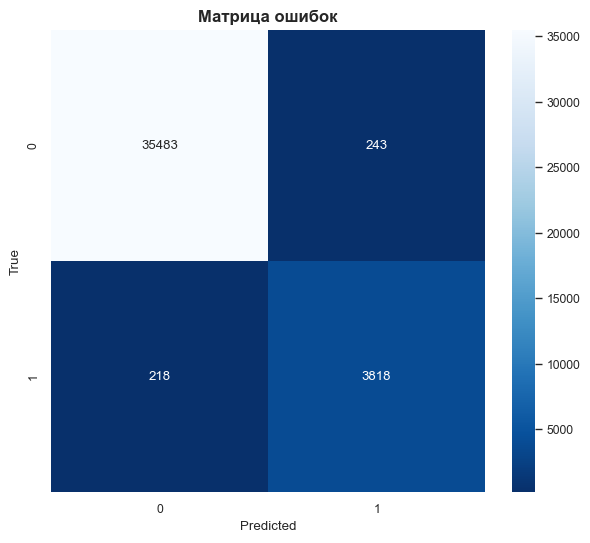

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     35726
           1       0.94      0.95      0.94      4036

    accuracy                           0.99     39762
   macro avg       0.97      0.97      0.97     39762
weighted avg       0.99      0.99      0.99     39762



In [52]:
# Оценка модели на тестовых данных
y_proba = model.predict_proba(X_test)[:, 1]
y_pred = (y_proba >= threshold_lr).astype(int)

# Матрица ошибок
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(7, 6))
matrix_plot = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues_r')

# Настройка заголовка и подписей
plt.title('Матрица ошибок', fontweight='bold', fontsize=12)
plt.xlabel('Predicted')
plt.ylabel('True')
    
# Вывод результатов
plt.show()

# Отчет по метрикам
print(classification_report(y_test, y_pred))

На тестовой выборке мы получили те же высокие значения метрик.

### Вывод:

На данном этапе мы подобрали гиперпараметры для моделей, выбрали ту, которая показала наилучшие показатели метрик и подобрали оптимальный порог срабатывания классификации.

**Лучшая модель:** `LogisticRegression`

**Гиперпараметры модели:**

```python
{
    'model': LogisticRegression(max_iter=5000,
                                class_weight='balanced', 
                                penalty='elasticnet', 
                                random_state=6011994, 
                                solver='saga', 
                                tol=0.001)
    'model__l1_ratio': 0.0, 
    'model__C': 0.1
}
```

**Метрики качества модели на тестовых данных:**

Метрики получены при пороге классификации: `0.87`

- `Precision` — `0.94`
- `Recall` — `0.95`
- `F1` — `0.94`

Метрики качества модели достигли необходимого уровня, требуемого в ТЗ.

## Общий вывод

**Описание проекта:**

Интернет-магазин запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

**Цель проекта:** Обучить модель выявлять негативные/токсичные комментарии, со значением метрики качества `F1` не меньше `0.75`. 

В вашем распоряжении 

**Описание данных:**

- `toxic_comments.csv` — набор данных с разметкой о токсичности правок.

**Описание признаков:**

- `text` — текст комментария;
- `toxic` — целевой признак.

**Ход исследования:**

- `Подготовка данных`: загрузка и изучение общей информации из представленных данных.


- `Предобработка данных`: очищенние текста от управляющих символов, приведение к нижнему регистру, поиск дубликатов.


- `Исследовательский анализ данных`: изучение входного признака и таргета, анализ их распределений (длина комментариев, распределение классов), поиск выбросов/аномалий в данных.


- `Обучение моделей и выбор лучшей`: подготовка данных для обучения моделей с помощью получения эмбеддингов моделью `unitary/toxic-bert`, преобразование тензора в 2х мерный массив методом `mean_pooling` и построенных пайплайнов, использование `RandomizedSearchCV` для поиска гиперпараметров для моделей, сравнение метрик на кросс-валидации и выбор лучшей модели, лучшей моделью делаем прогноз на тестовых данных и проводит анализ результатов.


- `Общий вывод`: резюмирование полученных результатов, формулировка ключевых выводов и рекомендаций.

**Результаты работы:**

Путем подбора гиперпараметров и оптимального порога классификации выбрана лучшая модель, которая была протестирована на тестовых данных.

**Лучшая модель:** `LogisticRegression`

**Гиперпараметры модели:**

```python
{
    'model': LogisticRegression(max_iter=5000,
                                class_weight='balanced', 
                                penalty='elasticnet', 
                                random_state=6011994, 
                                solver='saga', 
                                tol=0.001)
    'model__l1_ratio': 0.0, 
    'model__C': 0.1
}
```

**Метрики качества модели на тестовых данных:**

Метрики получены при пороге классификации: `0.87`

- `Precision` — `0.94`
- `Recall` — `0.95`
- `F1` — `0.94`

Метрики качества модели достигли необходимого уровня, требуемого в ТЗ.